In [1]:
!pip install -q tensorflow-model-optimization

In [18]:
import tempfile
import os

import tensorflow as tf

from tensorflow import keras

import tensorflow_model_optimization as tfmot

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
batch_size = 16
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)
data_dir = "dataset/final_images/"
base_learning_rate = 0.0003

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') 

Found 1352 images belonging to 5 classes.
Found 336 images belonging to 5 classes.


In [5]:
def define_model():
    
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')


    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(5, name="outputs", activation='softmax')
    
    x = base_model.output
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = prediction_layer(x)

    model = tf.keras.Model(base_model.input, outputs)
    
    return model




def freeze_model(model, fine_tune_at):

    model.trainable = True
    for layer in model.layers[:fine_tune_at]:
        model.trainable = False


# model = define_model()
# freeze_model(model, 10)

In [6]:
def apply_quantization_to_dense(layer_num):
    
    init_layer  = ('input_1', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded')
    blocks      = tuple([f'block_{i+1}_' for i in range(min(16, layer_num-1))])
    final_layer = ('Conv_1', 'Conv_1_bn', 'out_relu', 'global_average_pooling2d', 'dropout', 'outputs')
    
#     print(init_layer[:10*(layer_num>0)] + blocks + final_layer[:10*(layer_num>16)])
    
    def clone_function(layer):
        if not layer.name.startswith(init_layer[:10*(layer_num>0)] + blocks + final_layer[:10*(layer_num>16)]):
            return tfmot.quantization.keras.quantize_annotate_layer(layer)
        return layer
    
    return clone_function 




def quantisize_model(model, block_num):

    annotated_model = tf.keras.models.clone_model(
        model,
        clone_function=apply_quantization_to_dense(block_num),
    )

    quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
    return quant_aware_model

In [7]:
def train_model(model, epoch, lr):
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            train_generator,
            epochs=epoch,
            validation_data=validation_generator,
        )
        
    return history

In [11]:
block_history_dict = {}

for block_num in list(range(0, 17, 3)):
    
    print(f'[INFO]   Quantisizing starts from block: {block_num} '+'-'*100)
    
    model = tf.keras.models.load_model('models/celeb5_model_ft10.tf')
    
    quant_model = quantisize_model(model, block_num)
    
    history = train_model(quant_model, 2, 0.0001)
    
    block_history_dict[ block_num ] = history
    

[INFO]   Quantisizing starts from block: 0 ----------------------------------------------------------------------------------------------------
Epoch 1/2
85/85 [==============================] - 37s 328ms/step - loss: 0.1421 - accuracy: 0.9586 - val_loss: 0.6360 - val_accuracy: 0.7917
Epoch 2/2
85/85 [==============================] - 24s 284ms/step - loss: 0.0524 - accuracy: 0.9830 - val_loss: 0.9839 - val_accuracy: 0.8036
[INFO]   Quantisizing starts from block: 3 ----------------------------------------------------------------------------------------------------
Epoch 1/2
85/85 [==============================] - 31s 268ms/step - loss: 0.0700 - accuracy: 0.9786 - val_loss: 0.4467 - val_accuracy: 0.8869
Epoch 2/2
85/85 [==============================] - 22s 255ms/step - loss: 0.0379 - accuracy: 0.9867 - val_loss: 0.5322 - val_accuracy: 0.8780
[INFO]   Quantisizing starts from block: 6 ----------------------------------------------------------------------------------------------------


<AxesSubplot:>

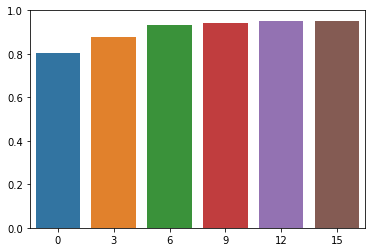

In [30]:
sns.barplot(
    x = [k for k, v in block_history_dict.items()],
    y = [v.history['val_accuracy'][-1] for k, v in block_history_dict.items()]
)